Note 1: we are now using the GPU!

Note 2: we are using torchvision to download built-in datasets

Note 3: we will now use batch gradient descent instead of full gradient descent

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [4]:
train_dataset = torchvision.datasets.MNIST(
    root='data_downloadable',
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
train_dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [6]:
test_dataset = torchvision.datasets.MNIST(
    root='data_downloadable',
    train=False,
    transform=transforms.ToTensor(),
    download=True,
)
test_dataset.data.shape

torch.Size([10000, 28, 28])

In [7]:
# Build the model
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# No need for final softmax! Its combined with CrossEntropyLoss

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [10]:
# Data loader
# Useful because it automatically generates batches in the training loop
# and takes care of shuffling

batch_size = 128

train_loader = torch.utils.data.DataLoader(
   dataset=train_dataset, 
   batch_size=batch_size, 
   shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

In [11]:
# Check out what the data loader does
# maps the values to (0, 1)
# makes the data of shape (batch size, color, height, width)
tmp_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=1, 
    shuffle=True,
)

for x, y in tmp_loader:
    print(x)
    print(x.shape)
    print(y.shape)
    break

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [12]:
train_dataset.transform(train_dataset.data.numpy()).max()

tensor(1.)

In [13]:
# Train the model
n_epochs = 10

# Stuff to store
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
  train_loss = []
  for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # reshape the input
    inputs = inputs.view(-1, 784)

    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
      
    # Backward and optimize
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

  # Get train loss and test loss
  train_loss = np.mean(train_loss) # a little misleading
  
  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  # Save losses
  train_losses[it] = train_loss
  test_losses[it] = test_loss
    
  print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/10, Train Loss: 0.4146, Test Loss: 0.2239
Epoch 2/10, Train Loss: 0.1945, Test Loss: 0.1595
Epoch 3/10, Train Loss: 0.1433, Test Loss: 0.1293
Epoch 4/10, Train Loss: 0.1126, Test Loss: 0.1112
Epoch 5/10, Train Loss: 0.0917, Test Loss: 0.1042
Epoch 6/10, Train Loss: 0.0767, Test Loss: 0.0927
Epoch 7/10, Train Loss: 0.0647, Test Loss: 0.0884
Epoch 8/10, Train Loss: 0.0547, Test Loss: 0.0791
Epoch 9/10, Train Loss: 0.0472, Test Loss: 0.0785
Epoch 10/10, Train Loss: 0.0408, Test Loss: 0.0738


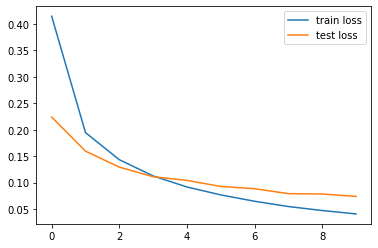

In [14]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [16]:
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # reshape the input
  inputs = inputs.view(-1, 784)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}")

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # reshape the input
  inputs = inputs.view(-1, 784)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

Train acc: 0.9920
Test acc: 0.9766


In [17]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

# Do these results make sense?
# It's easy to confuse 9 <--> 4, 9 <--> 7, 2 <--> 7, etc. 

Confusion matrix, without normalization
[[ 969    0    1    1    1    1    2    1    3    1]
 [   0 1124    3    1    0    1    2    1    3    0]
 [   3    1 1011    3    2    0    2    4    6    0]
 [   0    0    4  984    0    9    1    3    6    3]
 [   0    0    6    1  963    0    4    1    1    6]
 [   2    0    0    5    1  875    2    0    6    1]
 [   6    3    3    1    5    2  936    0    2    0]
 [   2    8   12    8    1    0    0  988    2    7]
 [   1    1    4    7    2    3    3    2  949    2]
 [   3    5    0    5    9    8    0    4    8  967]]


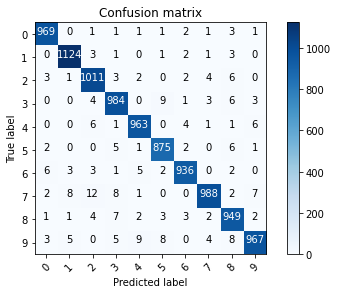

In [18]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs = inputs.to(device)

  # reshape the input
  inputs = inputs.view(-1, 784)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  
  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

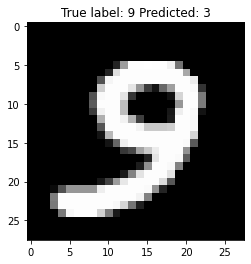

In [20]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], int(p_test[i])));